In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 4.5 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [6]:
# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [7]:
# ============================================
# 2. Obter POIs de interesse (pontos turísticos como exemplo)
# ============================================
tags = {'tourism': 'attraction'}
pois = ox.features.features_from_place(place, tags=tags)

# Extrair pontos representativos (centroides se for polígono)
tourist_points = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        tourist_points.append((row.geometry.y, row.geometry.x))
    else:
        tourist_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not tourist_points:
    print("Nenhum ponto turístico encontrado. Tentando outros tipos...")
    tags = {'tourism': 'viewpoint'}
    pois = ox.features.features_from_place(place, tags=tags)
    for idx, row in pois.iterrows():
        if row.geometry.geom_type == 'Point':
            tourist_points.append((row.geometry.y, row.geometry.x))
        else:
            tourist_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
    if not tourist_points:
        raise ValueError("Nenhum POI encontrado para as categorias tentadas.")


In [8]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [tp[0] for tp in tourist_points]
longitudes = [tp[1] for tp in tourist_points]
tourist_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
tourist_nodes = list(set(tourist_nodes))

if len(tourist_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(tourist_nodes)):
    for j in range(i+1, len(tourist_nodes)):
        route = nx.shortest_path(G_undirected, tourist_nodes[i], tourist_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(tourist_nodes[i], tourist_nodes[j], weight=route_length)

# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")


Comprimento total do MST entre os POIs selecionados: 28823.45123912635 metros


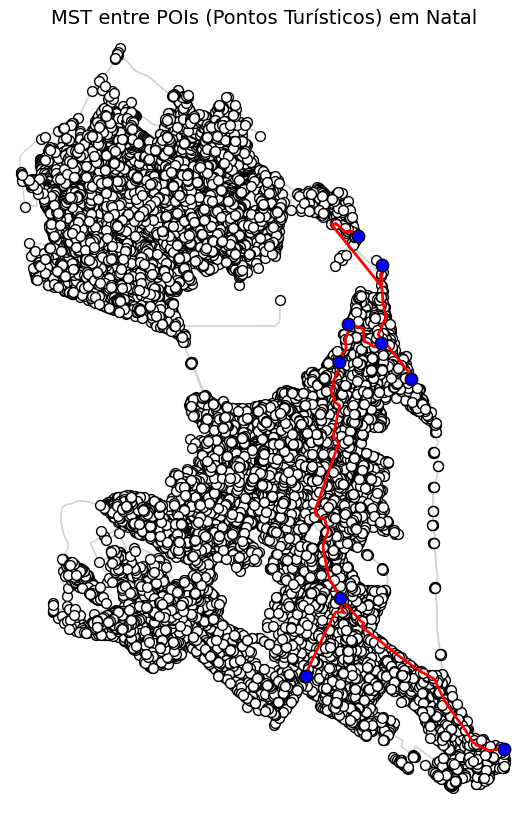

In [9]:
# Supondo que você já tenha as variáveis:
# G_undirected: grafo MultiGraph não-direcionado
# tourist_nodes: lista de nós próximos aos pontos turísticos
# mst_edges: lista de arestas do MST (u, v, dados da aresta)
# latitudes, longitudes: listas com lat/long dos pontos turísticos

# Caso não tenha sido definido, você pode calcular um bbox se quiser
# bbox_padding = 0.02
# north = max(latitudes) + bbox_padding
# south = min(latitudes) - bbox_padding
# east = max(longitudes) + bbox_padding
# west = min(longitudes) - bbox_padding

# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected,
    # Caso queira o bbox, descomente a linha abaixo:
    # bbox=(north, south, east, west),
    show=False,
    close=False,
    node_color='white',
    node_edgecolor='black',
    node_size=50,
    edge_color='lightgray',
    edge_linewidth=1,
    bgcolor='white',    # fundo branco
    figsize=(10,10)
)

# Criar a lista de rotas do MST
mst_routes = []
for u, v, d in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (pontos turísticos) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in tourist_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in tourist_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black')

plt.title("MST entre POIs (Pontos Turísticos) em Natal", fontsize=14)
plt.show()


In [11]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# ============================================
# Adicionar nomes dos locais destacados
# ============================================
# Supondo que tourist_nodes contém os nós dos pontos turísticos
# E tourist_points contém os nomes e coordenadas dos locais
local_names = [
    "Praia de Ponta Negra",
    "Forte dos Reis Magos",
    "Parque das Dunas",
    "Arena das Dunas",
    "Morro do Careca",
    "Museu Câmara Cascudo",
    "Barreira do Inferno",
    "Praia do Meio"
]

# Criar um dicionário para mapear os nós aos nomes
tourist_node_names = {node: name for node, name in zip(tourist_nodes, local_names)}

# Mostrar os locais destacados
print("Locais Destacados:")
for node, name in tourist_node_names.items():
    print(f"Nó: {node}, Local: {name}")


Locais Destacados:
Nó: 7168038295, Local: Praia de Ponta Negra
Nó: 5443212811, Local: Forte dos Reis Magos
Nó: 301646157, Local: Parque das Dunas
Nó: 7629917326, Local: Arena das Dunas
Nó: 501834705, Local: Morro do Careca
Nó: 7284391573, Local: Museu Câmara Cascudo
Nó: 505029815, Local: Barreira do Inferno
Nó: 316330427, Local: Praia do Meio
